### Imports

In [1]:
import sys
sys.path.insert(0, 'D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Classes')

import warnings
warnings.filterwarnings('ignore')

from models import ClassificationModel, EmbeddingsModel, SiameseModel
from trainer import SiameseTrainerCombinationDataset, all_subjects

import torch
import json


### Set Hyperparameters

In [2]:
subjects_test = all_subjects[:13]
subjects_train = [sub for sub in all_subjects if sub not in subjects_test]

In [3]:
trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\XITE\\normalized_subjects_no_outliner.pkl",
    "subjects_train": subjects_train,
    "subjects_test": subjects_test,
    "wandb": False,
    "log": True,
    "learning_rate": 0.01,
    "batch_size": 256,
    "batch_size_test": 256,
    "freeze_embed": False,
    "dataset_ignore_subject_train": True,
    "dataset_ignore_subject_test": False,
    "decision_function": 0,
    "filter": [1, 2, 3, -1, -2, -3],
    "weight_decay": 0.001,
    "lr_steps": 10,
    "adam": True,
    "number_steps": 200,
    "number_steps_testing": 200,
    "number_steps_histogramm": None
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.2,
        "layers": [207, 512, 64]
}

model_classifier_hyperparameter = {
    "dropout": 0.2,
    "layers": [64, 32]
}

### Init models

In [4]:
classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

# #
#  0 = abs(sub())
#  1 = euclid
#  2 = cos_simil
# #

In [5]:
#_ = embedding_model.load_state_dict(torch.load("D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Results\models\embedding_models\model_abs_acc_89.40.pth"))

In [6]:
filter = lambda data: data["label"].isin(trainer_hyperparameter["filter"])
trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0", filter=filter)

### start training

In [12]:
trainer.trainloop(30)

epoch: 1 | train_acc: 0.5909 | test_acc: 0.6523
epoch: 2 | train_acc: 0.6089 | test_acc: 0.6537
epoch: 3 | train_acc: 0.6107 | test_acc: 0.6639
epoch: 4 | train_acc: 0.6164 | test_acc: 0.6508
epoch: 5 | train_acc: 0.613 | test_acc: 0.6628
epoch: 6 | train_acc: 0.6156 | test_acc: 0.6624
epoch: 7 | train_acc: 0.6148 | test_acc: 0.6627
epoch: 8 | train_acc: 0.6167 | test_acc: 0.6598
epoch: 9 | train_acc: 0.6146 | test_acc: 0.6721
epoch: 10 | train_acc: 0.6128 | test_acc: 0.6602
epoch: 11 | train_acc: 0.6286 | test_acc: 0.6816
epoch: 12 | train_acc: 0.6357 | test_acc: 0.6854
epoch: 13 | train_acc: 0.6337 | test_acc: 0.6872
epoch: 14 | train_acc: 0.6386 | test_acc: 0.6908
epoch: 15 | train_acc: 0.6367 | test_acc: 0.6968
epoch: 16 | train_acc: 0.64 | test_acc: 0.6907
epoch: 17 | train_acc: 0.6405 | test_acc: 0.6875
epoch: 18 | train_acc: 0.6389 | test_acc: 0.695
epoch: 19 | train_acc: 0.6419 | test_acc: 0.7003
epoch: 20 | train_acc: 0.6415 | test_acc: 0.6927
epoch: 21 | train_acc: 0.6436 | t

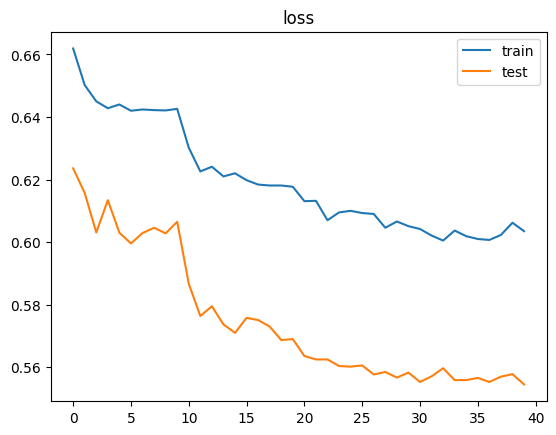

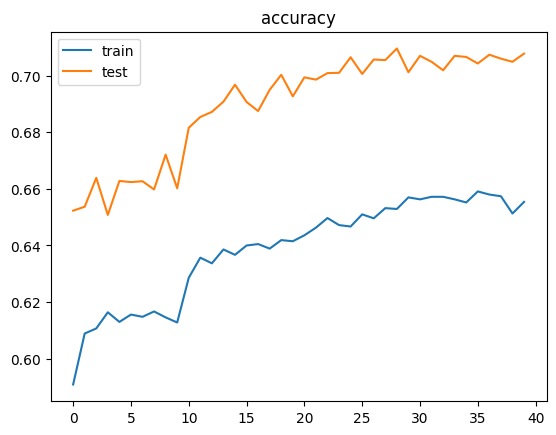

In [13]:
trainer.plot_history()

### plot additional result data

In [14]:
best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
cm = trainer.history_cm[best_epoch-1]["cm"]

print("acc:", trainer.history[best_epoch-1]["test_acc"])

acc: 0.7096


In [15]:
trainer.calculate_f_scores(cm)

{'recall': 0.7158283377664854,
 'precision': 0.6984969396451538,
 'f1': 0.7070564476599416}

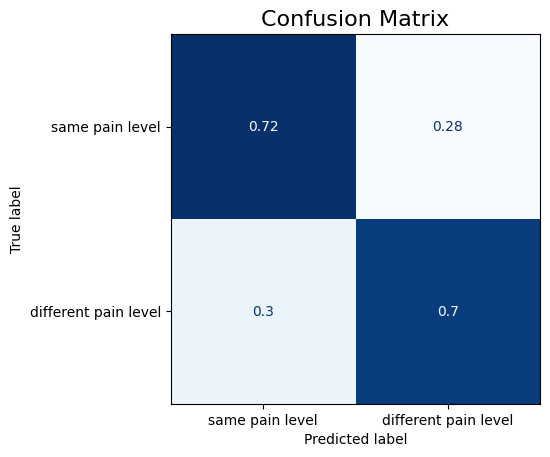

In [16]:
trainer.plot_cm(cm)

100%|██████████| 816/816 [11:42<00:00,  1.16it/s]


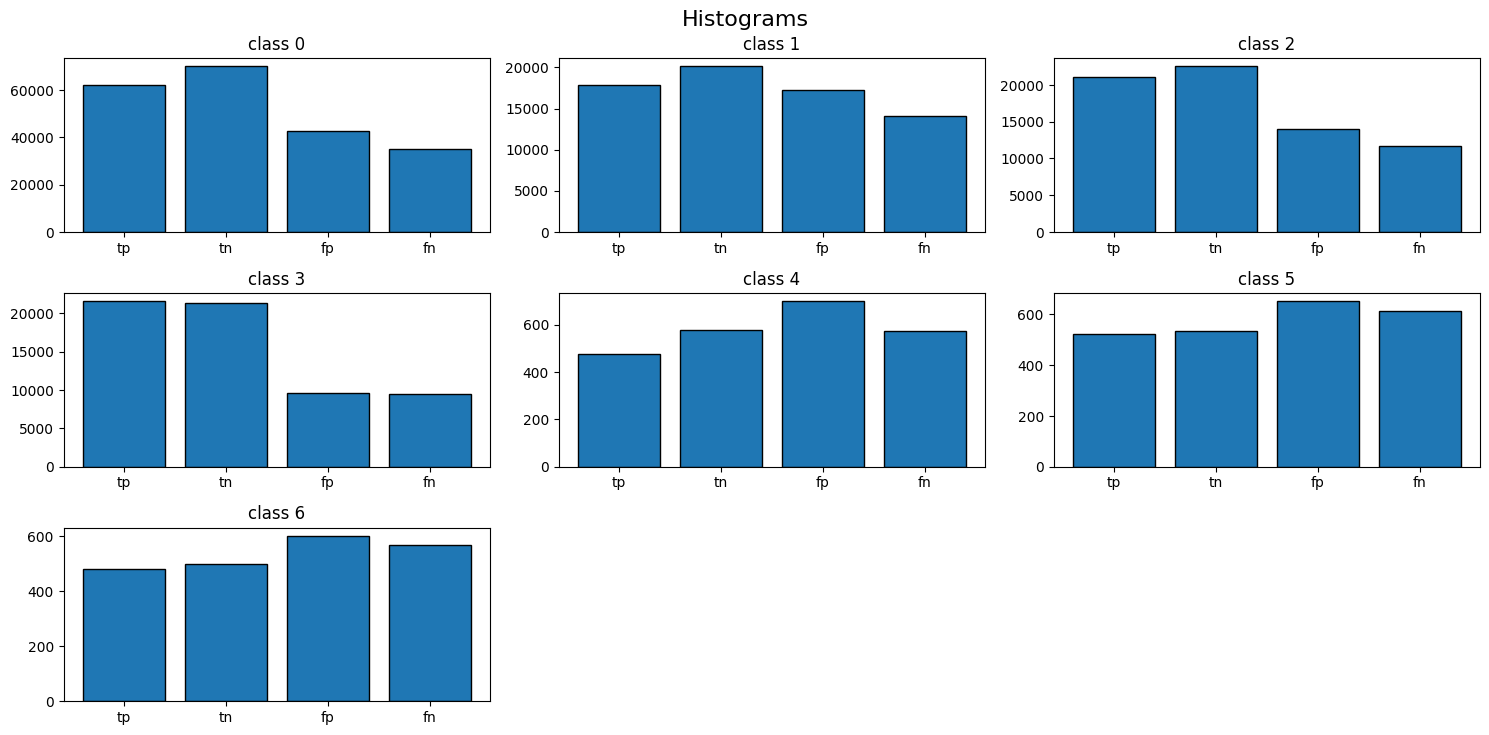

In [12]:
trainer.display_histograms()

### Save best testing result to file

In [ ]:
best_acc = trainer.history[best_epoch]["test_acc"]

epochs = len(trainer.history)

path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Results\siamese_model_results\combination_dataset.json"
trainer_hyp = trainer_hyperparameter.copy()
del trainer_hyp["subjects_train"]
del trainer_hyp["path"]
del trainer_hyp["wandb"]
del trainer_hyp["log"]

data_to_save = [{"trainer_hyperparameter": trainer_hyp,
        "model_embedding_hyperparameter": model_embedding_hyperparameter,
        "model_classifier_hyperparameter": model_classifier_hyperparameter,
        "acc": best_acc,
        "epochs": epochs}]
        
try:
    with open(path) as infile:
        data = json.load(infile)
except:
    data = []

data.extend(data_to_save)
with open(path, 'w') as fp:
    json.dump(data, fp, sort_keys=True, indent=4)